In [4]:
# base environment
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,roc_auc_score,f1_score

In [5]:
#df=pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\combined_data_English.xlsx")
df= pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Eng_standard.xlsx")

In [6]:
df

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,...,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,...,249.0,2.9,8.699406,0,1,0,1,1.00000,22.222222,0
1,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,...,152.0,12.5,8.699406,0,1,0,1,1.00000,25.826446,0
2,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,...,126.0,3.7,1.690000,0,1,0,1,0.00000,19.531250,0
3,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,...,146.0,5.1,8.699406,0,1,0,1,0.63176,23.857203,0
4,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,...,143.0,5.4,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,...,139.0,9.3,8.699406,0,1,0,1,1.00000,28.081633,0
27907,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,...,151.0,3.9,8.699406,0,1,0,1,0.00000,26.175195,0
27908,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,...,195.0,7.6,1.280000,0,1,0,1,1.00000,18.591130,0
27909,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,...,183.0,7.5,0.750000,0,0,0,0,0.00000,24.243918,0


In [7]:
pd.set_option('display.max_columns', None)

In [8]:
y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop([ '癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [9]:
for i in range(54):
    print(X_train[0][i])

-1.8115041
0.034456912
0.06397885
-0.044075925
-0.03192871
1.195248
-0.8561826
-0.14718731
-0.22813907
1.2565697
-0.7529751
-0.04278305
-0.7301886
-0.4797452
-0.31302163
0.2677639
0.3841175
0.3924039
-0.7859731
0.58226603
-0.6159577
0.37682533
0.7486662
-0.6195082
0.4226502
-1.61859
-0.7115336
-1.201203
-1.0402976
-0.4554284
-1.7570161
-0.11042372
0.46170464
-0.1488745
-0.08075255
0.596847
0.23027614
0.48971978
-0.3224804
-0.45881927
-0.27999634
-0.5294442
0.13190547
-0.46724725
-0.43197212
-0.60022587
-0.18454894
-0.11740204
1.6613815
-0.696752
2.2778213
-0.954115
-1.3853531
-0.065567225


In [10]:
X_train

array([[-1.8115041 ,  0.03445691,  0.06397885, ..., -0.954115  ,
        -1.3853531 , -0.06556723],
       [ 1.012286  , -0.507434  , -1.1311655 , ...,  1.0480918 ,
         0.80376124,  0.09486606],
       [-0.71336347, -0.22071925,  0.35924983, ..., -0.954115  ,
        -1.3853531 , -0.02740239],
       ...,
       [ 0.4632157 , -0.894499  , -0.49844205, ..., -0.954115  ,
        -1.3853531 , -0.08392414],
       [-0.24273181, -0.04869037,  0.62639976, ...,  1.0480918 ,
         0.80376124, -0.03523465],
       [ 0.5416543 , -0.34113947,  0.35924983, ...,  1.0480918 ,
         0.80376124, -0.0760267 ]], dtype=float32)

In [11]:
from sklearn import linear_model

accuracy=[];
nonzero_coef=[];

for n in tqdm(range(500)):
    a= n*0.0002+0.001
    clf = linear_model.Lasso(alpha=a)
    clf.fit(X_train,y_train)
    nonzero_num=len(clf.coef_.nonzero()[0])
    nonzero_coef.append(nonzero_num)
    #print(clf.coef_)
    predicted_y=clf.predict(X_test)
    for i in range(len(predicted_y)):
        if predicted_y[i]>0.5:
            predicted_y[i]=1
        else:
            predicted_y[i]=0
    accuracy.append(accuracy_score(y_test,predicted_y))


  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
print(accuracy,nonzero_coef)

[0.8208848289450117, 0.8203474834318467, 0.8203474834318467, 0.8201683682607916, 0.8205265986029017, 0.8203474834318467, 0.8203474834318467, 0.8201683682607916, 0.8205265986029017, 0.8207057137739566, 0.8208848289450117, 0.8205265986029017, 0.8199892530897367, 0.8194519075765717, 0.8190936772344618, 0.8190936772344618, 0.8194519075765717, 0.8190936772344618, 0.8190936772344618, 0.8185563317212968, 0.8181981013791868, 0.8183772165502418, 0.8187354468923518, 0.8185563317212968, 0.8183772165502418, 0.8174816406949669, 0.8176607558660218, 0.8176607558660218, 0.8165860648396919, 0.8164069496686369, 0.816227834497582, 0.815332258642307, 0.815153143471252, 0.814974028300197, 0.814794913129142, 0.815153143471252, 0.814974028300197, 0.814615797958087, 0.8142575676159771, 0.8142575676159771, 0.814615797958087, 0.814794913129142, 0.8142575676159771, 0.8144366827870321, 0.8144366827870321, 0.8144366827870321, 0.8142575676159771, 0.814078452444922, 0.8131828765896472, 0.8128246462475371, 0.81246641

In [13]:
x=[];
y=[];
for i in range(68):
    try:
        index=nonzero_coef.index(i)
        x.append(i)
        y.append(accuracy[index])
    except:
        pass;

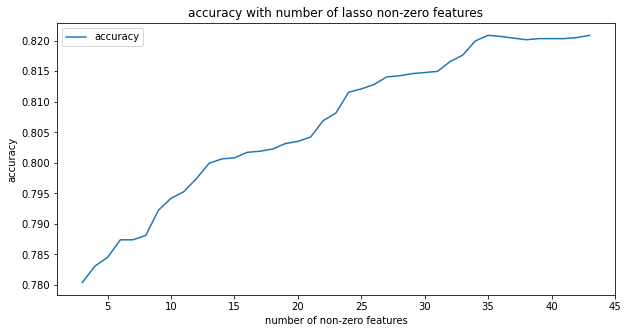

In [14]:
f, ax= plt.subplots(figsize = (10, 5))
fig=plt.plot(x,y,label="accuracy")
ax.set_title('accuracy with number of lasso non-zero features')
ax.set_xlabel("number of non-zero features")
ax.set_ylabel("accuracy")
ax.legend()
plt.show()

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

x_train = X_train
x_test = X_test

LR = LogisticRegression(max_iter=1000)
OLS = LinearRegression()

accuracy=[];
auc=[];
features_num=[];
survive_name=list(X.columns);
rank=[]

for i in tqdm(range(X.shape[1]-1)):
    n=X.shape[1]-(i+1)
    sfs = SequentialFeatureSelector(OLS, n_features_to_select=n,direction="backward")
    sfs.fit(x_train, y_train)
    
    del_column = list(sfs.get_support()).index(False)
    del_item=survive_name[del_column]
    del survive_name[del_column]
    print(survive_name)
    
    x_train=sfs.transform(x_train)
    x_test=sfs.transform(x_test)
    
    
    LR.fit(x_train,y_train)
    y_pred=LR.predict(x_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    auc.append(roc_auc_score(y_test,y_pred))
    features_num.append(n)
    rank.append(del_item)

  0%|          | 0/53 [00:00<?, ?it/s]

['Age', 'WBC', 'Lym', 'Mon', 'Ne', 'Eos', 'Baso', 'Lym%', 'Mon%', 'Eos%', 'Baso%', 'Ne%', 'RBC', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW', 'PLT', 'MPV', 'PCT', 'PDW', 'P-LCR', 'Urea', 'Na+', 'K+', 'Cl-', 'Glu', 'Creatinine', 'CO₂CP', 'Uric Acid', 'CA19-9', 'TBIL', 'DBIL', 'TP', 'ALB', 'Globulin', 'A/G\xa0', 'ALT', 'AST', 'ALP', 'TBA', 'γ-GT', 'Prealbumin', 'LDH', 'IBIL', 'CEA', 'FIT positive', "FIT's data is missing'", 'Fecal transferrin positive', "Fecal transferrin's data is missing'", 'Gender', 'BMI']
['Age', 'WBC', 'Lym', 'Mon', 'Ne', 'Eos', 'Baso', 'Lym%', 'Mon%', 'Eos%', 'Baso%', 'Ne%', 'RBC', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW', 'PLT', 'MPV', 'PCT', 'P-LCR', 'Urea', 'Na+', 'K+', 'Cl-', 'Glu', 'Creatinine', 'CO₂CP', 'Uric Acid', 'CA19-9', 'TBIL', 'DBIL', 'TP', 'ALB', 'Globulin', 'A/G\xa0', 'ALT', 'AST', 'ALP', 'TBA', 'γ-GT', 'Prealbumin', 'LDH', 'IBIL', 'CEA', 'FIT positive', "FIT's data is missing'", 'Fecal transferrin positive', "Fecal transferrin's data is missing'", 'Gender', 'BMI']

['Age', 'Lym', 'Ne', 'Mon%', 'Eos%', 'Baso%', 'Ne%', 'RBC', 'HCT', 'MCV', 'RDW', 'PLT', 'MPV', 'P-LCR', 'Urea', 'Na+', 'K+', 'Cl-', 'Glu', 'Creatinine', 'CA19-9', 'TP', 'ALB', 'Globulin', 'ALT', 'TBA', 'Prealbumin', 'IBIL', 'CEA', 'FIT positive', "FIT's data is missing'", 'Fecal transferrin positive', "Fecal transferrin's data is missing'", 'Gender']
['Age', 'Lym', 'Mon%', 'Eos%', 'Baso%', 'Ne%', 'RBC', 'HCT', 'MCV', 'RDW', 'PLT', 'MPV', 'P-LCR', 'Urea', 'Na+', 'K+', 'Cl-', 'Glu', 'Creatinine', 'CA19-9', 'TP', 'ALB', 'Globulin', 'ALT', 'TBA', 'Prealbumin', 'IBIL', 'CEA', 'FIT positive', "FIT's data is missing'", 'Fecal transferrin positive', "Fecal transferrin's data is missing'", 'Gender']
['Age', 'Lym', 'Mon%', 'Eos%', 'Baso%', 'Ne%', 'RBC', 'HCT', 'MCV', 'RDW', 'PLT', 'MPV', 'P-LCR', 'Urea', 'Na+', 'K+', 'Cl-', 'Creatinine', 'CA19-9', 'TP', 'ALB', 'Globulin', 'ALT', 'TBA', 'Prealbumin', 'IBIL', 'CEA', 'FIT positive', "FIT's data is missing'", 'Fecal transferrin positive', "Fecal tra

In [16]:
rank[::-1]

['RDW',
 'Prealbumin',
 "Fecal transferrin's data is missing'",
 'MCV',
 "FIT's data is missing'",
 'Lym',
 'Na+',
 'Age',
 'K+',
 'Urea',
 'RBC',
 'Gender',
 'Fecal transferrin positive',
 'P-LCR',
 'Mon%',
 'TBA',
 'Eos%',
 'Baso%',
 'CEA',
 'PLT',
 'Cl-',
 'MPV',
 'Globulin',
 'CA19-9',
 'ALT',
 'ALB',
 'TP',
 'IBIL',
 'Creatinine',
 'Ne%',
 'HCT',
 'Glu',
 'Ne',
 'ALP',
 'DBIL',
 'MCHC',
 'MCH',
 'LDH',
 'Baso',
 'CO₂CP',
 'BMI',
 'Lym%',
 'γ-GT',
 'A/G\xa0',
 'TBIL',
 'Eos',
 'AST',
 'Uric Acid',
 'Mon',
 'WBC',
 'PCT',
 'PDW',
 'Hb']

In [17]:
accuracy

[0.8284076661293212,
 0.8282285509582662,
 0.8284076661293212,
 0.8285867813003761,
 0.8284076661293212,
 0.8282285509582662,
 0.8294823571556511,
 0.8291241268135411,
 0.8289450116424861,
 0.8287658964714312,
 0.8289450116424861,
 0.8287658964714312,
 0.8287658964714312,
 0.829303241984596,
 0.8296614723267061,
 0.829840587497761,
 0.830198817839871,
 0.8289450116424861,
 0.8289450116424861,
 0.8276912054451012,
 0.8278703206161562,
 0.8282285509582662,
 0.8275120902740463,
 0.8284076661293212,
 0.8285867813003761,
 0.8262582840766612,
 0.8275120902740463,
 0.8269747447608813,
 0.8282285509582662,
 0.8278703206161562,
 0.8248253627082214,
 0.8257209385634964,
 0.8269747447608813,
 0.8275120902740463,
 0.8257209385634964,
 0.8259000537345513,
 0.8244671323661114,
 0.8246462475371664,
 0.8250044778792763,
 0.8216012896292316,
 0.8232133261687264,
 0.8207057137739566,
 0.8223177503134516,
 0.8207057137739566,
 0.8212430592871216,
 0.8207057137739566,
 0.8187354468923518,
 0.8167651800107

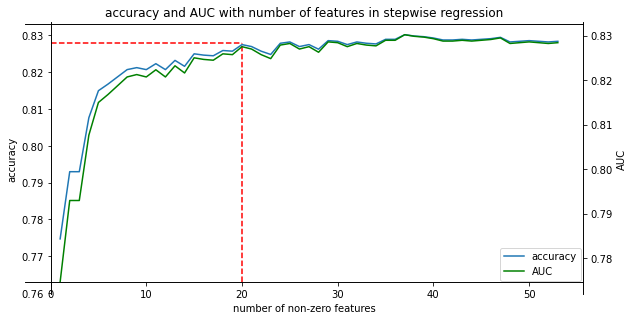

In [18]:
accuracy = accuracy[::-1]
auc = auc[::-1]
features_num = features_num[::-1]

f, ax= plt.subplots(figsize = (10, 5))
p1=plt.plot(features_num,accuracy,label="accuracy")
ax.set_title('accuracy and AUC with number of features in stepwise regression')
ax.set_xlabel("number of non-zero features")
ax.set_ylabel("accuracy")
ax.vlines(20, 0.763, 0.828, colors = "r", linestyles = "dashed")
ax.hlines(0.828, 0, 20, colors = "r", linestyles = "dashed")

ax2 = ax.twinx()
p2=ax2.plot(features_num,accuracy,label="AUC",color="green")
ax2.set_ylabel("AUC")
#ax2.legend(loc=0)


#ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')

#移位置 设为原点相交
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0.763))
ax.spines['top'].set_position(('data',0.833))

ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))

ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('data',0.7746))
ax2.spines['top'].set_position(('data',0.8325))

ax2.yaxis.set_ticks_position('right')
ax2.spines['left'].set_position(('data',0))

p=p1+p2
labs = [l.get_label() for l in p]
ax.legend(p, labs,loc=(0.85,0.05))



plt.show()


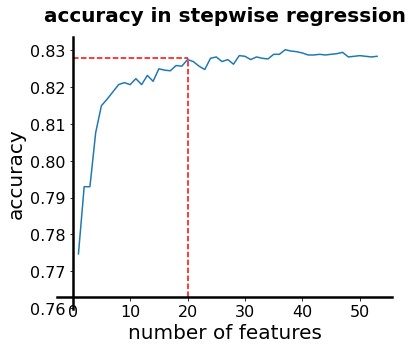

In [77]:
#单纯只有accuracy的版本(Fig4)
f, ax= plt.subplots(figsize = (6, 5))
p1=plt.plot(features_num,accuracy,label="accuracy")
ax.set_title('accuracy in stepwise regression',fontsize=20,pad=16,fontweight="bold")
ax.set_xlabel("number of features",fontsize=20)
ax.set_ylabel("accuracy",fontsize=20)
ax.tick_params(labelsize=16) 
ax.vlines(20, 0.763, 0.828, colors = "r", linestyles = "dashed")
ax.hlines(0.828, 0, 20, colors = "r", linestyles = "dashed")


#ax2.legend(loc=0)


#ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')

#移位置 设为原点相交
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0.763))
ax.spines['top'].set_position(('data',0.833))

ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))


p=p1
labs = [l.get_label() for l in p]
#ax.legend(p, labs,loc=(0.85,0.05))


# set linewidth of the frame
for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.annotate('(a)', xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)



#plt.show()
plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig4.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

